In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()
from influxdb_client import InfluxDBClient
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
import dateutil.parser

# Import Dataset

In [2]:
#Auth parameters
my_token = "yaKfFeAsha8tNAZxvYeZBMmq-khO8tz-6Ut_PARgohiWzeW2j8BB86ND33Qbq7hR8bylmOROPQAUr-7M103_Yw=="
my_org = "iot-org"
bucket = "iot-demo"
client = InfluxDBClient(url="http://192.168.1.100:9999", token=my_token, org=my_org, debug=False)

In [3]:
days = '5d'
n_days = 5

queryTemperature = '''
from(bucket: "iot-demo")
  |> range(start: -%s, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "temperature")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 10m, fn: median)
  ''' % days

queryHumidity = '''
from(bucket: "iot-demo")
  |> range(start: -%s, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "humidity")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 10m, fn: median)
  ''' % days

queryPressure = '''
from(bucket: "iot-demo")
  |> range(start: -%s, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "pressure")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 10m, fn: median)
  ''' % days

In [43]:
#Query InfluxDB and return a Dataframe
dfTemp = client.query_api().query_data_frame(org=my_org, query=queryTemperature)
dfHum = client.query_api().query_data_frame(org=my_org, query=queryHumidity)
dfPress = client.query_api().query_data_frame(org=my_org, query=queryPressure)

In [44]:
df = pd.DataFrame(dfTemp['_time']).rename(columns={'_time':'time'})
df['temperature'] = dfTemp['_value']
df['humidity'] = dfHum['_value']
df['pressure'] = dfPress['_value']
df = df.set_index('time')
df = df.asfreq(freq='600S')
df.head()

,temperature,humidity,pressure
time,,,
2020-07-08 10:30:00+00:00,28.0,43.0,NaN
2020-07-08 10:40:00+00:00,28.1,42.9,NaN
2020-07-08 10:50:00+00:00,NaN,42.5,NaN
2020-07-08 11:00:00+00:00,28.2,41.8,NaN
2020-07-08 11:10:00+00:00,28.2,41.6,NaN


In [45]:
#raw_csv_data = pd.read_csv("./temperature.csv") 
#df=raw_csv_data.copy()
#df=df.rename(columns={'_time':'time', '_value':'temperature'})
#del df['_start']
#del df['_stop']
#del df['_measurement']
#del df['device']
#del df['location']
#del df['result']
#del df['_field']
#del df['table']
#del df['null_col']
#df.time = pd.to_datetime(df.time, dayfirst = True)
#df = df.set_index('time')
#df.head()

In [46]:
df['temperature'] = df['temperature'].fillna(method='backfill')#.fillna(method='ffill')
df['humidity'] = df['humidity'].fillna(method='backfill')
df['pressure'] = df['pressure'].fillna(method='backfill').fillna(method='ffill')

In [47]:
points_per_day = int(len(df)/n_days) 
points_per_day

144

In [48]:
print(df['temperature'].isnull().sum())
print(df['humidity'].isnull().sum())
print(df['pressure'].isnull().sum())

0
0
0


In [49]:
normalized_df=(df-df.min())/(df.max()-df.min())

print(df['temperature'].max())
print(df['humidity'].max())
print(df['pressure'].max())
print(df['temperature'].min())
print(df['humidity'].min())
print(df['pressure'].min())

print(normalized_df['temperature'].max())
print(normalized_df['humidity'].max())
print(normalized_df['pressure'].max())
print(normalized_df['temperature'].min())
print(normalized_df['humidity'].min())
print(normalized_df['pressure'].min())

33.8
54.45
1024.75
27.6
36.0
1015.0
1.0
1.0
1.0
0.0
0.0
0.0


In [50]:
# divide in train e test
size = int(len(df)*0.8)
df_train, df_test = df.iloc[:size], df.iloc[size:]

# Predicting temperature

In [51]:
sts.adfuller(df.temperature) # stazionaria

(-3.252199738873666,
 0.017155121285434397,
 14,
 705,
 {'1%': -3.4396596024765795,
  '5%': -2.86564834926679,
  '10%': -2.568957779286756},
 -754.0765692528405)

## AR Model

In [52]:
df_test.head()

,temperature,humidity,pressure
time,,,
2020-07-12 10:30:00+00:00,29.00,51.80,1024.5
2020-07-12 10:40:00+00:00,28.90,51.60,1023.5
2020-07-12 10:50:00+00:00,28.80,51.80,1023.5
2020-07-12 11:00:00+00:00,28.75,51.80,1023.5
2020-07-12 11:10:00+00:00,28.85,51.85,1023.5


In [53]:
df_test.tail()

,temperature,humidity,pressure
time,,,
2020-07-13 09:40:00+00:00,28.20,45.00,1024.5
2020-07-13 09:50:00+00:00,28.30,45.10,1024.5
2020-07-13 10:00:00+00:00,28.25,45.00,1024.5
2020-07-13 10:10:00+00:00,28.25,44.70,1024.5
2020-07-13 10:20:00+00:00,28.35,44.05,1024.5


In [69]:
start_date = datetime.fromisoformat('2020-07-12 10:30:00+00:00')
end_date = datetime.fromisoformat('2020-07-13 10:20:00+00:00')

# Temperature

                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                  576
Model:             SARIMAX(1, 1, 2)x(0, 1, [], 144)   Log Likelihood                 140.729
Date:                              Mon, 13 Jul 2020   AIC                           -271.457
Time:                                      13:19:01   BIC                           -251.127
Sample:                                  07-08-2020   HQIC                          -263.430
                                       - 07-12-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
humidity      -0.1104      0.018     -6.165      0.000      -0.146      -0.075
ar.L1          0.72

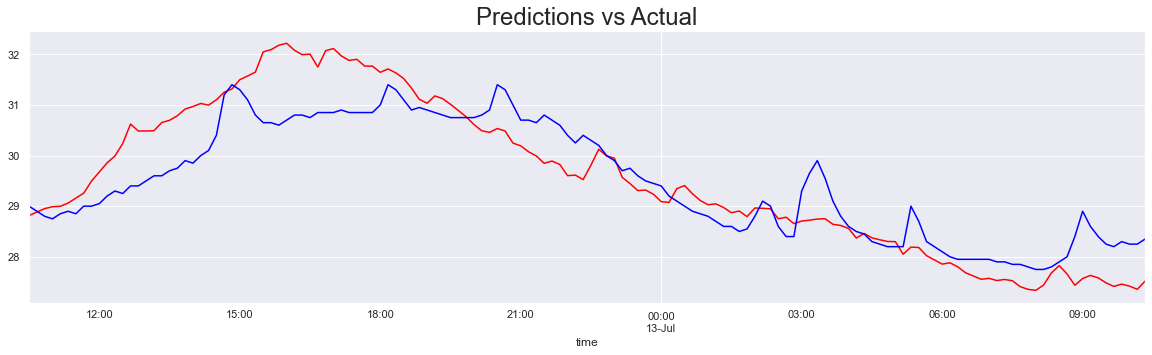

ABSOLUTE ERROR 0.536884560746818
MSE 0.4426330977640273


In [99]:
model_t = SARIMAX(df_train.temperature, order = (1,1,2), seasonal_order = (0,1,0,144), exog = df_train[["humidity"]])
results_t = model_t.fit()
print(results_t.summary())

df_pred_t = results_t.predict(start = start_date, end = end_date, exog = df_test[["humidity"]])

df_pred_t[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.temperature[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.temperature[start_date:end_date], df_pred_t[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred_t[start_date:end_date])))

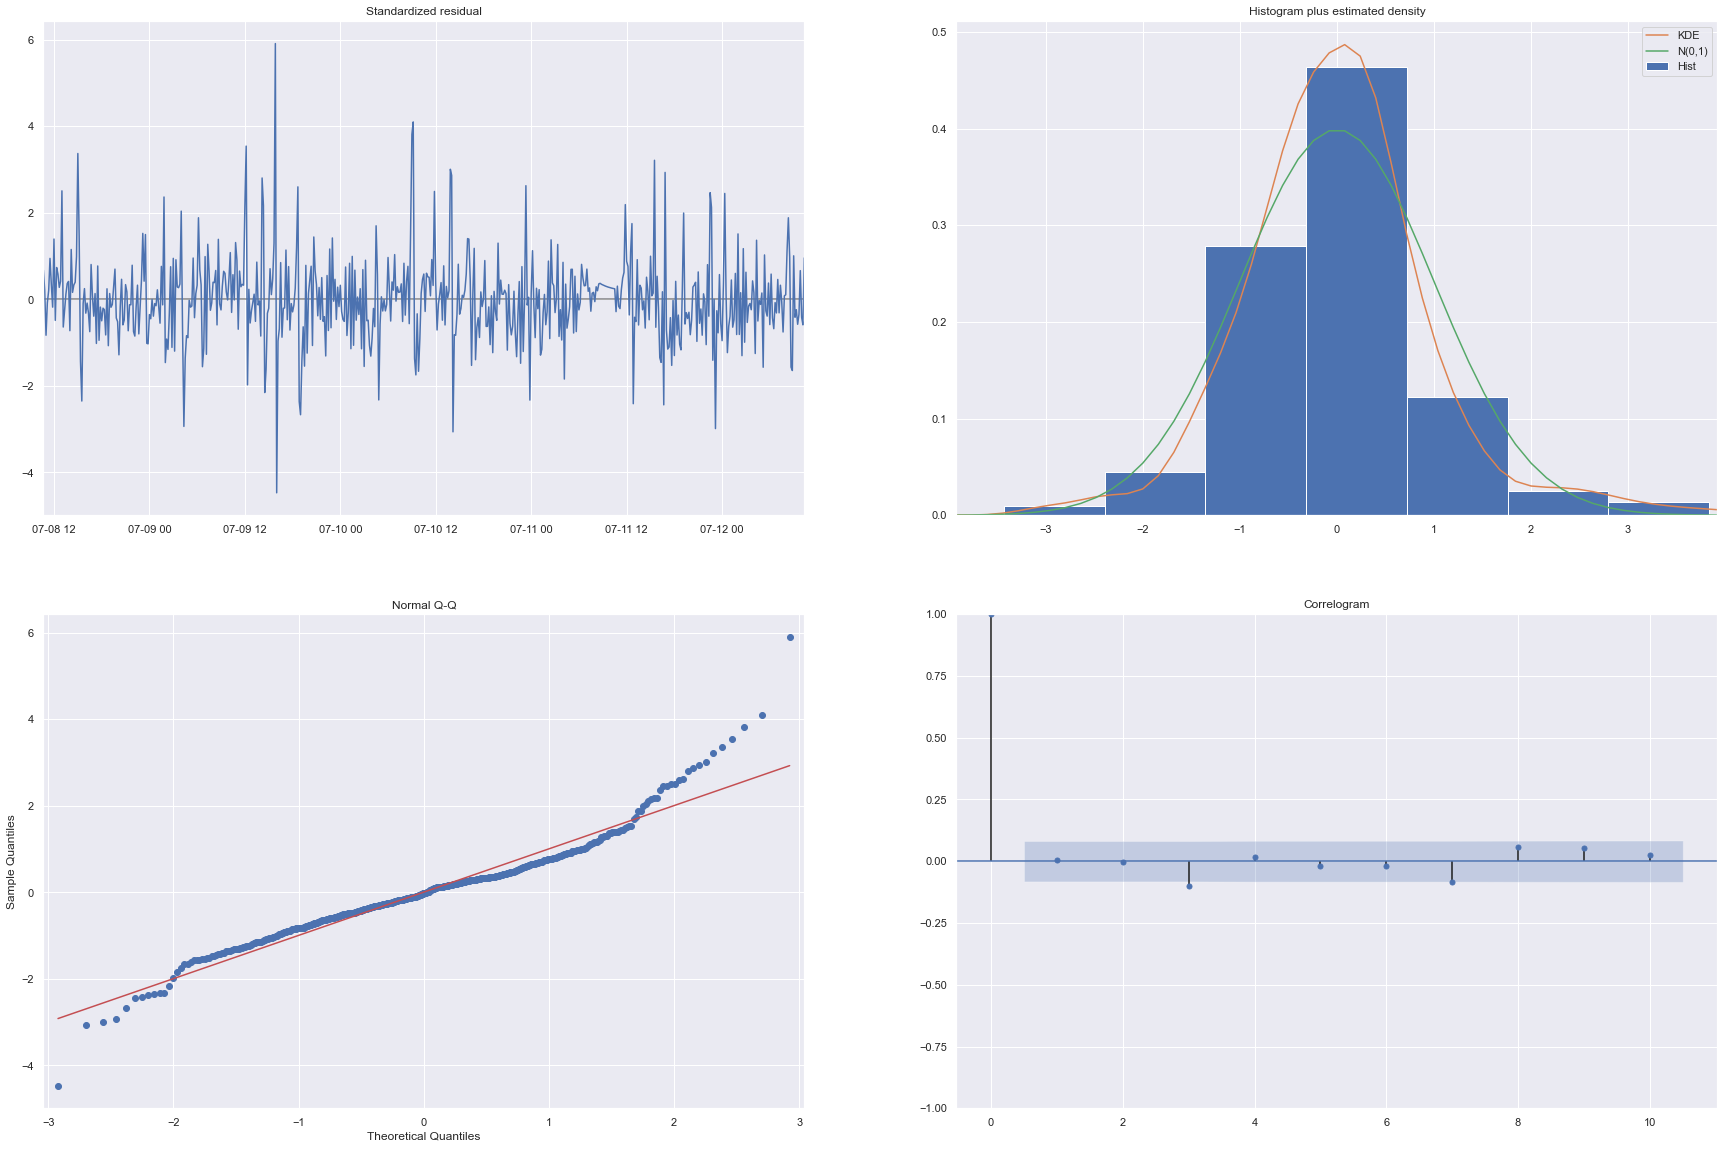

In [68]:
results_t.plot_diagnostics(figsize = (30,20))
plt.show()

# Pressure

                               SARIMAX Results                                
Dep. Variable:               pressure   No. Observations:                  576
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  -9.684
Date:                Mon, 13 Jul 2020   AIC                             25.369
Time:                        12:55:04   BIC                             38.432
Sample:                    07-08-2020   HQIC                            30.463
                         - 07-12-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6333      0.377     -1.679      0.093      -1.373       0.106
ma.L1          0.5694      0.418      1.363      0.173      -0.249       1.388
sigma2         0.0606      0.001     83.650      0.0

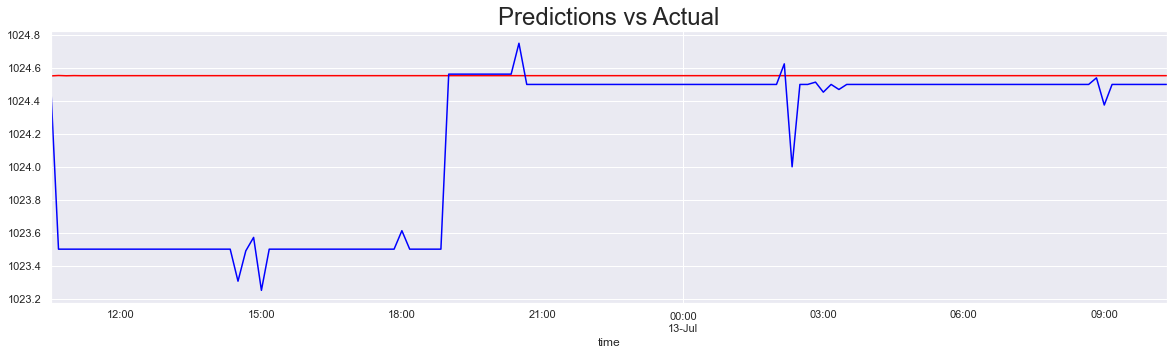

ABSOLUTE ERROR 0.40522132328352317
MSE 0.3942749369821618


In [90]:
model_p = SARIMAX(df_train.pressure, order = (1,1,1))
results_p = model_p.fit()
print(results_p.summary())

df_pred_p = results_p.predict(start = start_date, end = end_date)

df_pred_p[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.pressure[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.pressure[start_date:end_date], df_pred_p[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.pressure[start_date:end_date], df_pred_p[start_date:end_date])))

# Humidity

In [ ]:
model_h = SARIMAX(df_train.humidity, order = (2,0,0), seasonal_order = (0,1,2,144), exog = df_train[["temperature", "pressure"]])
results_h = model_h.fit()
print(results_h.summary())

df_pred_h = results_h.predict(start = start_date, end = end_date, exog = df_test[["temperature", "pressure"]])

df_pred_h[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.humidity[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

print(df_test.humidity[start_date:end_date].head())
print(df_pred_h[start_date:end_date].head)

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.humidity[start_date:end_date], df_pred_h[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.humidity[start_date:end_date], df_pred_h[start_date:end_date])))